# One class SVM for Anomaly Detection

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import util
import importlib
import pywt

importlib.reload(util)

<module 'util' from '/Users/stan/Desktop/UCU/linear-algebra/course-project/util.py'>

Prototyping of the intrusion detection system, based on the BCCC-CIC-IDS-2017 dataset.

In [4]:
# Load the data

data = util.read_all_files()

data['timestamp'] = pd.to_datetime(data['timestamp'], format='mixed')
data = data.set_index('timestamp')
data = data.sort_index()

# Main

In [6]:
normal_traffic_df = data[data['label'] == 'Benign'].loc['2017-07-05']


In [7]:
print(data.loc['2017-07-07'].label.value_counts())

label
Benign         364102
Port_Scan      161323
DDoS_LOIT       95733
Botnet_ARES      5508
Name: count, dtype: int64


In [8]:
normal_traffic_df.label.value_counts()

label
Benign    397053
Name: count, dtype: int64

In [9]:
data_scaler = StandardScaler()

dwt_df, _ = util.preprocess(normal_traffic_df, data_scaler.fit_transform, all=True)
# dwt2_df, _ = util.preprocess(data[data['label'] == 'Benign'].loc['2017-07-05'], data_scaler.transform)


# dwt_df = pd.concat([dwt_df, dwt2_df]).reset_index(drop=True)

dwt_df

,ddos_loit
0,0.841206
1,0.844186
2,0.845118
3,0.839457
4,0.839303
...,...
30447,0.842751
30448,0.842312
30449,0.842819
30450,0.843562


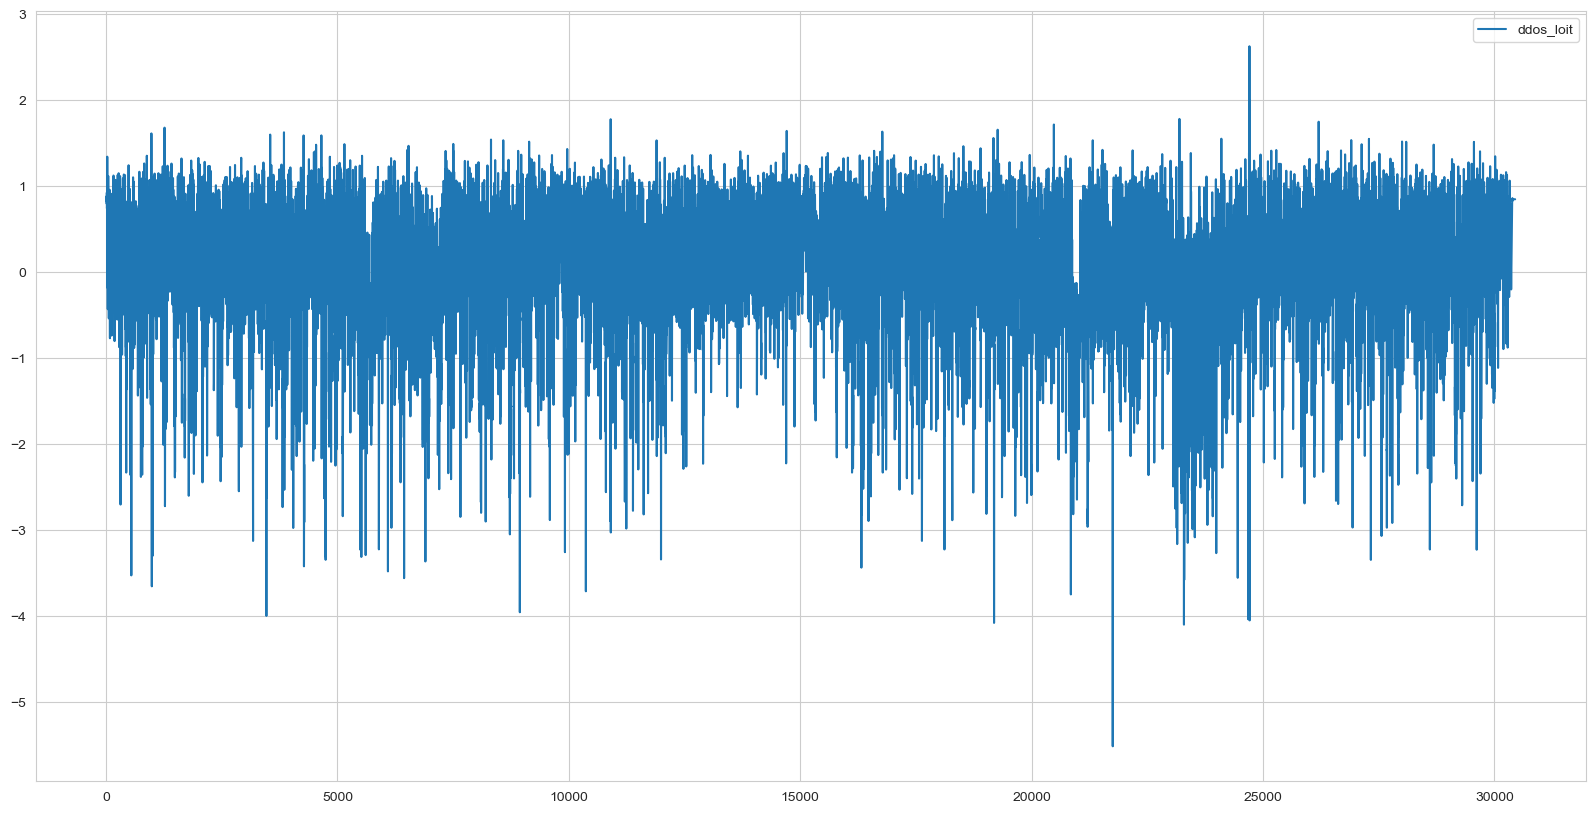

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(dwt_df)
plt.legend(dwt_df.columns)
plt.show()

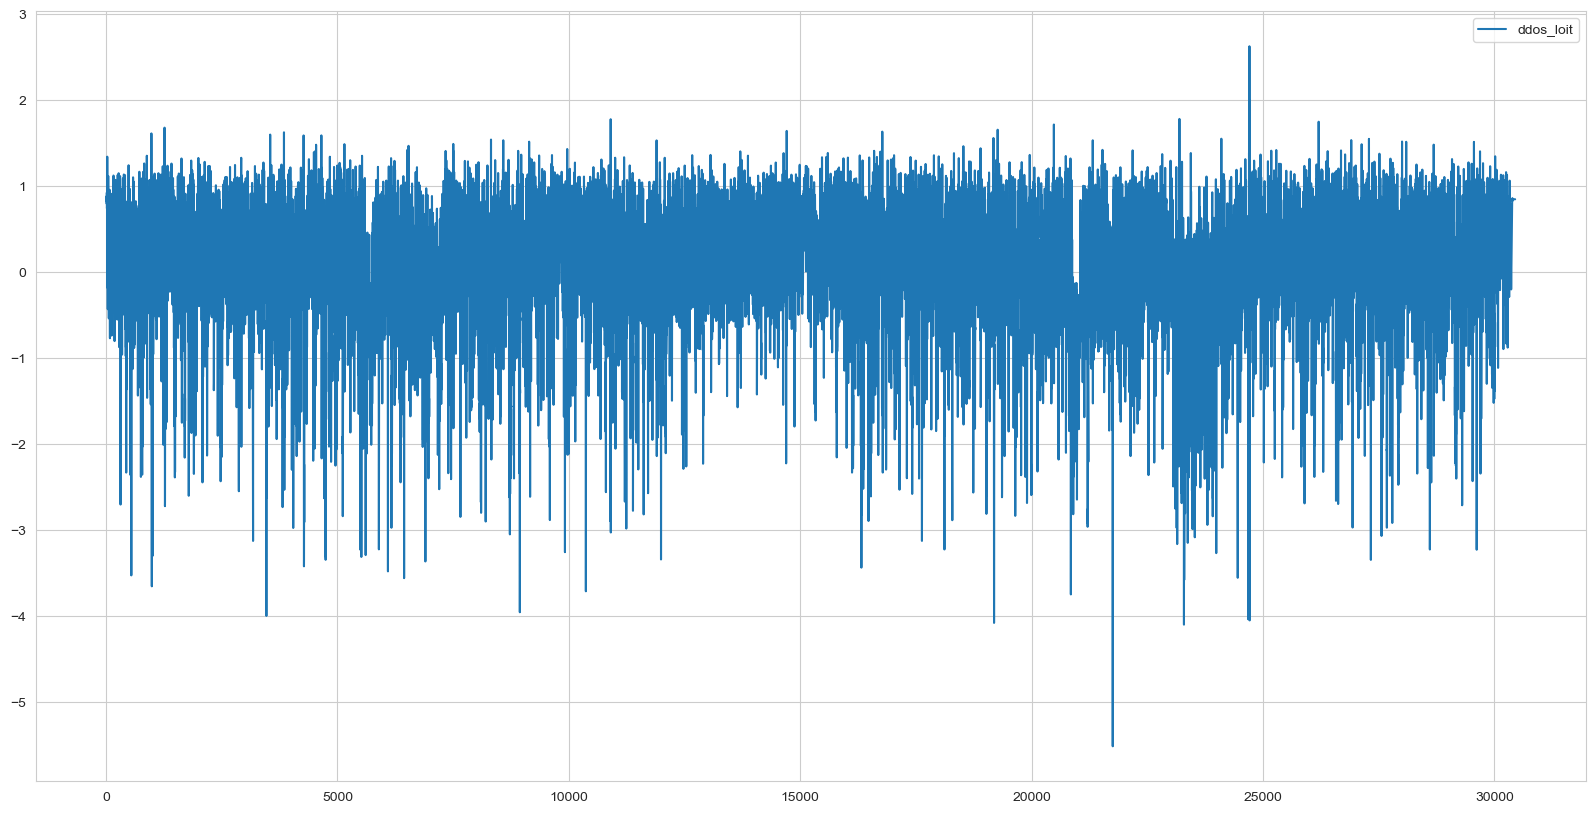

label
Benign       364102
DDoS_LOIT     95733
Name: count, dtype: int64
Filtering only internal traffic


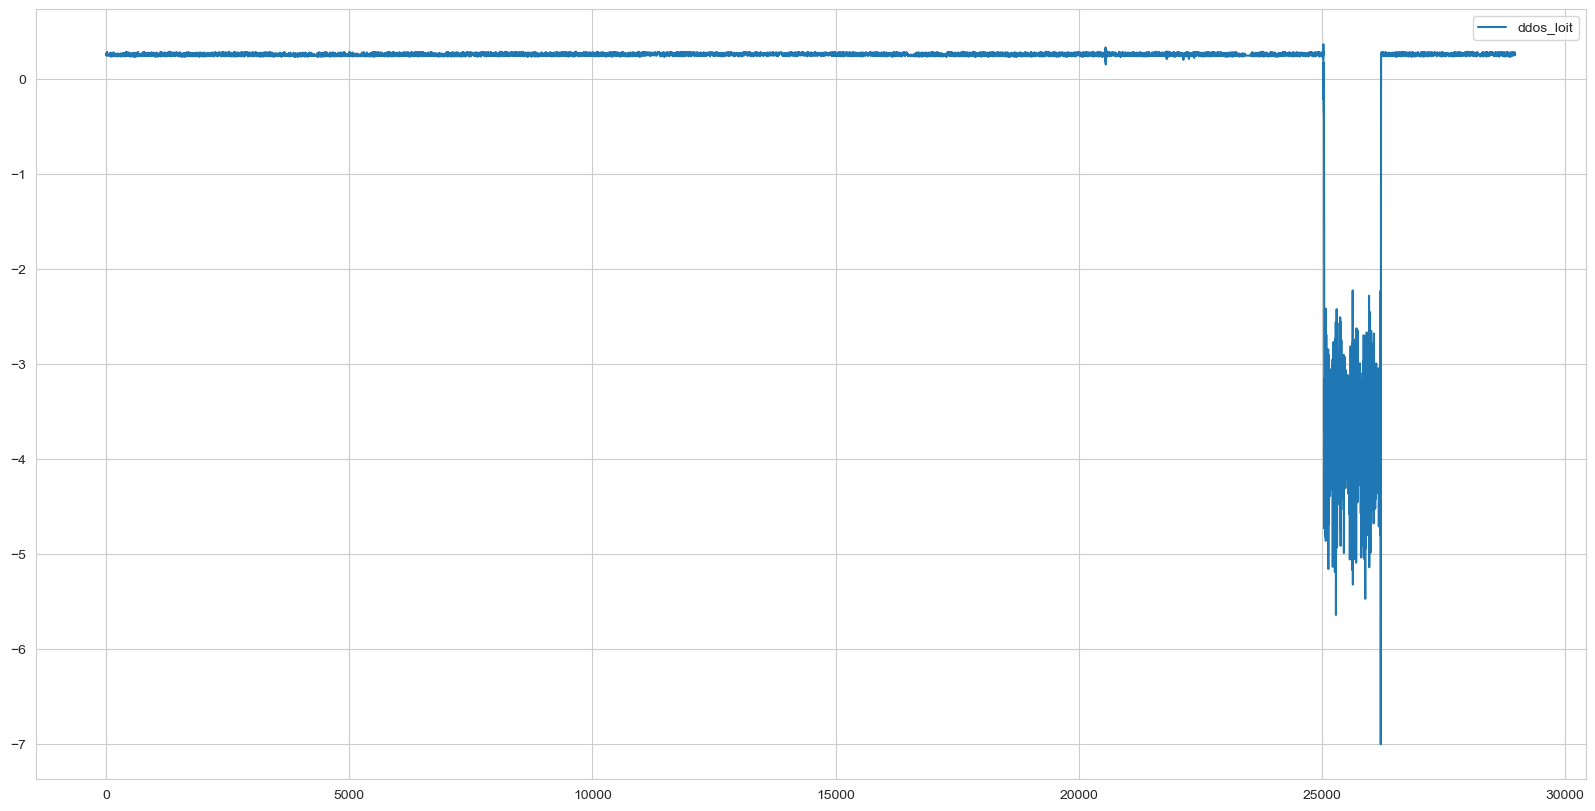

,ddos_loit
0,0.270083
1,0.261141
2,0.255890
3,0.256905
4,0.261755
...,...
28967,0.256605
28968,0.250519
28969,0.252657
28970,0.264630


<Figure size 2000x1000 with 0 Axes>

In [18]:
from sklearn.ensemble import IsolationForest
import optuna
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# Scale the data
X = dwt_df

plt.figure(figsize=(20, 10))
plt.plot(X)
plt.legend(dwt_df.columns)
plt.show()

def data_by_date_and_labels(data, date, labels = None):
    if labels is None:
        return data.loc[date]
    return data.loc[date].loc[data.loc[date].label.isin(labels)]

# Load malicious data
# mal_df = data_by_date_and_labels(data, '2017-07-05', ['Benign', 'DoS_Hulk'])
# mal_df = data_by_date_and_labels(data, '2017-07-05', ['DoS_Hulk'])
mal_df = data_by_date_and_labels(data, '2017-07-07', ['Benign', 'DDoS_LOIT'])
# mal_df = data_by_date_and_labels(data, '2017-07-05')

print(mal_df.label.value_counts())

X_test, y_true = util.preprocess(mal_df, data_scaler.transform, all=False)

plt.figure(figsize=(20, 10))
plt.plot(X_test)
plt.legend(dwt_df.columns)
plt.show()

display(X_test)

plt.figure(figsize=(20, 10))
# plt.legend(dwt_df.columns)
plt.show()

In [12]:
# plt.figure(figsize=(20, 10))
# plt.scatter(X_test['fwd_payload_bytes_variance'], X_test['duration'])
# plt.show()

# One class SVM for Anomaly Detection

[I 2025-02-07 22:39:58,011] A new study created in memory with name: no-name-6dab8c84-0d73-4758-8311-02840fb4b162


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-07 22:39:59,691] Trial 0 finished with value: 0.9239662072032014 and parameters: {'nu': 0.0331777686229022, 'gamma': 0.005424738229263667}. Best is trial 0 with value: 0.9239662072032014.
[I 2025-02-07 22:40:01,711] Trial 8 finished with value: 0.9244444444444444 and parameters: {'nu': 0.03912935373686573, 'gamma': 0.008478630760996642}. Best is trial 8 with value: 0.9244444444444444.
[I 2025-02-07 22:40:02,504] Trial 2 finished with value: 0.9240337627721013 and parameters: {'nu': 0.09028517150862368, 'gamma': 0.0019397851682336938}. Best is trial 8 with value: 0.9244444444444444.
[I 2025-02-07 22:40:03,108] Trial 5 finished with value: 0.9240337627721013 and parameters: {'nu': 0.10158535657263457, 'gamma': 0.00973352326988556}. Best is trial 8 with value: 0.9244444444444444.
[I 2025-02-07 22:40:03,883] Trial 7 finished with value: 0.9240337627721013 and parameters: {'nu': 0.12047515961289483, 'gamma': 0.005216857229518422}. Best is trial 8 with value: 0.9244444444444444.
[

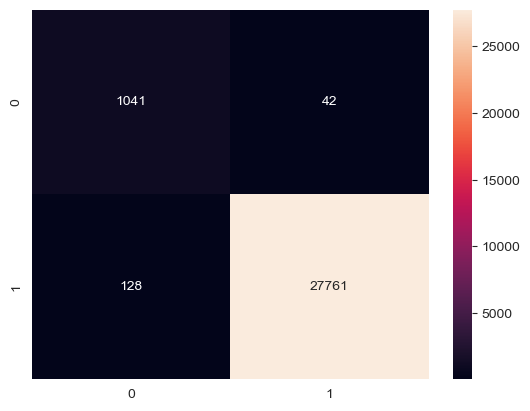

In [13]:
def objective(trial):
    clf = OneClassSVM(nu=trial.suggest_float("nu", 0.001, 0.2), kernel="rbf", cache_size=1000, gamma=trial.suggest_float("gamma", 0.001, 0.01))
    clf.fit(X)
    y_pred = clf.predict(X_test)

    return f1_score(y_true, y_pred, average="binary", pos_label=-1)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=8, show_progress_bar=True)

print("Best Parameters:", study.best_params)

print("best score:", study.best_value)

clf = OneClassSVM(nu=study.best_params['nu'], gamma=study.best_params['gamma'], kernel="rbf", cache_size=1000)
# clf = OneClassSVM(nu=0.05, gamma=0.1, kernel="rbf", cache_size=1000)
clf.fit(X)

y_pred = clf.predict(X_test)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
print(classification_report(y_true, y_pred))

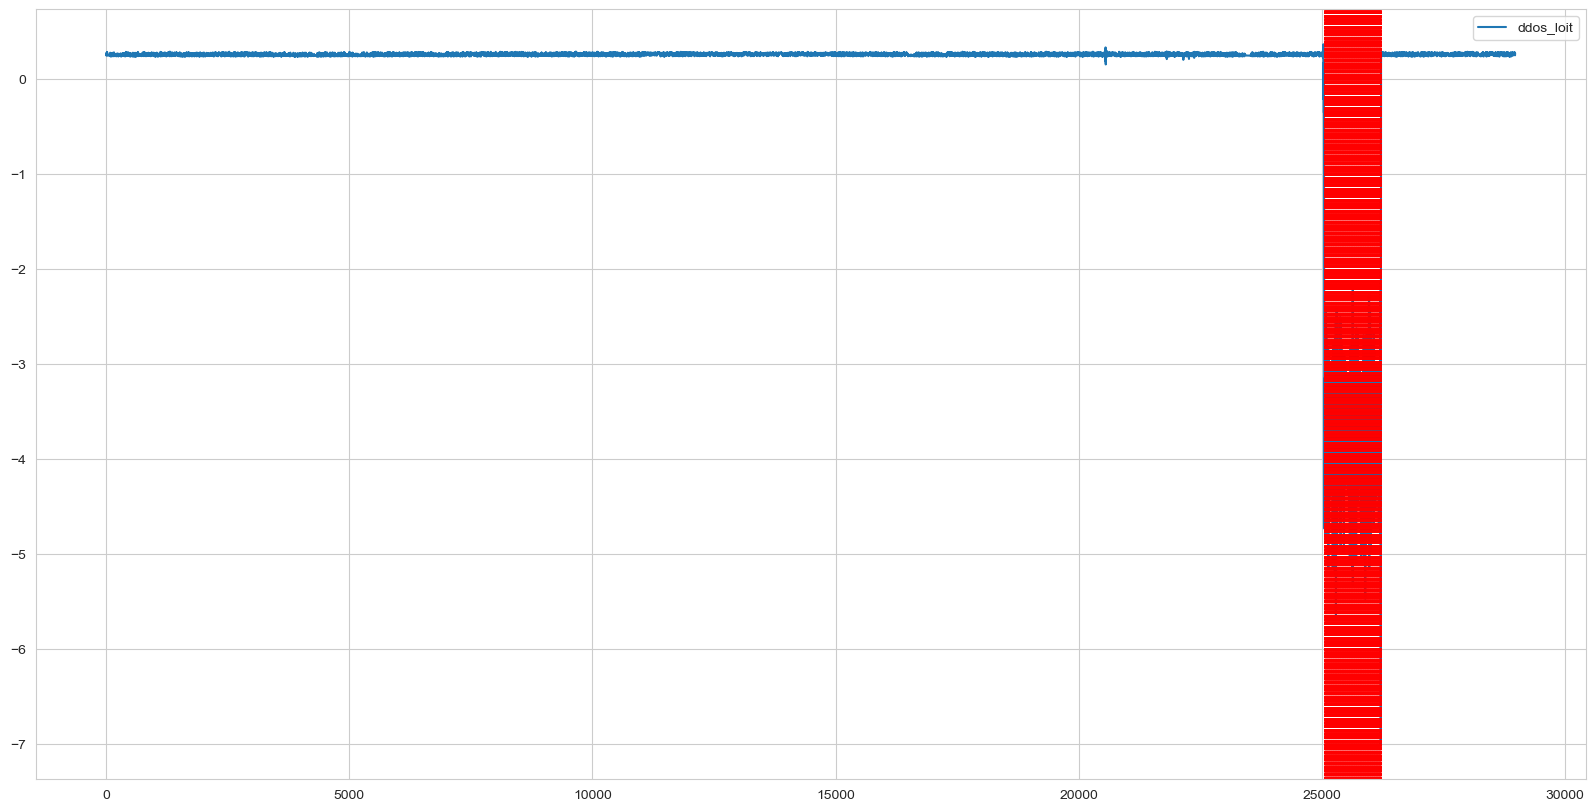

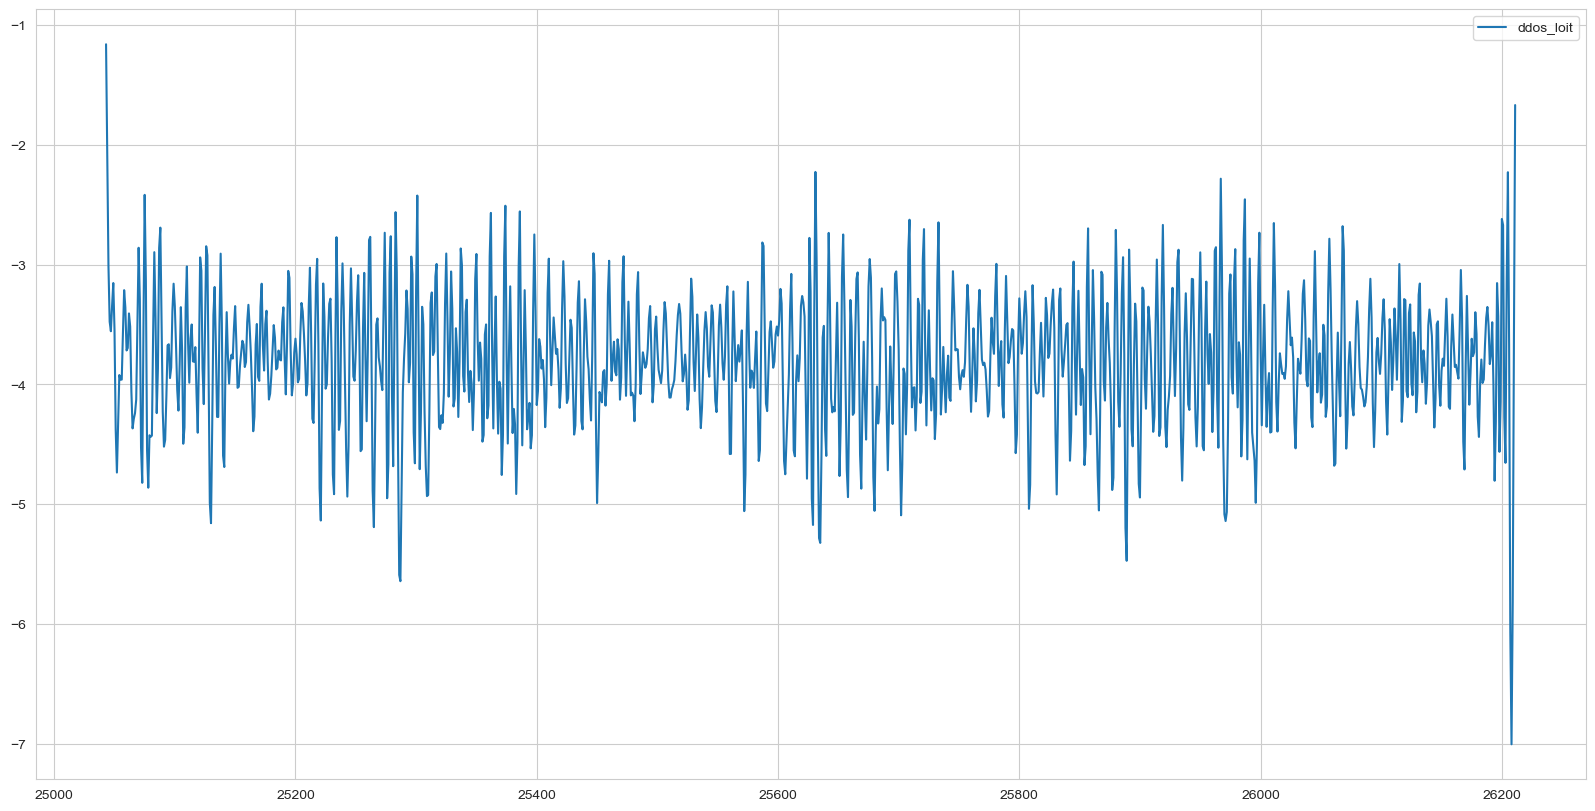

In [14]:
# plot outliers on test data

plt.figure(figsize=(20, 10))
plt.plot(X_test)

# for i in range(len(X_test[y_pred == -1])):
#     plt.axvline(, 0, 1, color='r', linestyle='dashed')

for i in X_test[y_pred == -1].index:
    plt.axvline(i, 0, 1, color='r', linestyle='dashed', linewidth=0.5)

plt.legend(dwt_df.columns)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(X_test[y_pred == -1])
plt.legend(dwt_df.columns)
plt.show()

# Isolation Forest for Anomaly Detection

[I 2025-02-07 22:41:38,464] A new study created in memory with name: no-name-28aa0014-c547-4f61-bf4a-3c221050aa9e


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-07 22:41:39,708] Trial 1 finished with value: 0.9239662072032014 and parameters: {'contamination': 0.024564596861166663}. Best is trial 1 with value: 0.9239662072032014.
[I 2025-02-07 22:41:39,715] Trial 5 finished with value: 0.9239662072032014 and parameters: {'contamination': 0.02200626517786326}. Best is trial 1 with value: 0.9239662072032014.
[I 2025-02-07 22:41:39,727] Trial 2 finished with value: 0.9240337627721013 and parameters: {'contamination': 0.056092337878721386}. Best is trial 2 with value: 0.9240337627721013.
[I 2025-02-07 22:41:39,729] Trial 3 finished with value: 0.9240337627721013 and parameters: {'contamination': 0.055940492856434876}. Best is trial 2 with value: 0.9240337627721013.
[I 2025-02-07 22:41:39,731] Trial 7 finished with value: 0.9239662072032014 and parameters: {'contamination': 0.024611422641338067}. Best is trial 2 with value: 0.9240337627721013.
[I 2025-02-07 22:41:39,748] Trial 4 finished with value: 0.9239662072032014 and parameters: {'co

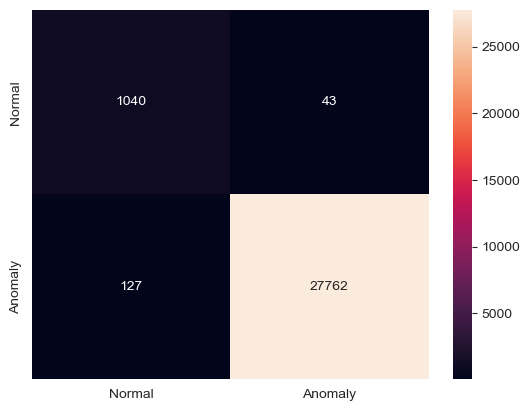

In [15]:
# # one class svm

# # from math import gamma
# from sklearn.svm import OneClassSVM

# scaler = StandardScaler()
# X = scaler.fit_transform(dwt_df)

# X_test = util.preprocess(data.loc['2017-07-07'])
# X_test = scaler.transform(X_test)


# from matplotlib.pyplot import show


def objective(trial):
    c = trial.suggest_float("contamination", 0.001, 0.1)  # Nu controls outlier proportion
    # gamma = trial.suggest_float("gamma", 0.001, 10)  # Influence of data points

    # Train One-Class SVM
    clf = IsolationForest(contamination=c, bootstrap=True, random_state=3123)
    clf.fit(X)

    y_pred = clf.predict(X_test)

    # Evaluate using F1-score (or AUC-ROC if you prefer)
    return f1_score(y_true, y_pred, average="binary", pos_label=-1)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=8, show_progress_bar=True)

print("Best Parameters:", study.best_params)

print("best score:", study.best_value)

clf = IsolationForest(contamination=study.best_params['contamination'], bootstrap=True, random_state=3123)
# clf = IsolationForest(max_samples=1.0, contamination=0.05, n_estimators=800, random_state=1234)
clf.fit(X)

y_pred = clf.predict(X_test)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
print(classification_report(y_true, y_pred))

# clf = OneClassSVM(nu=0.01, gamma=10)
# clf.fit(X)

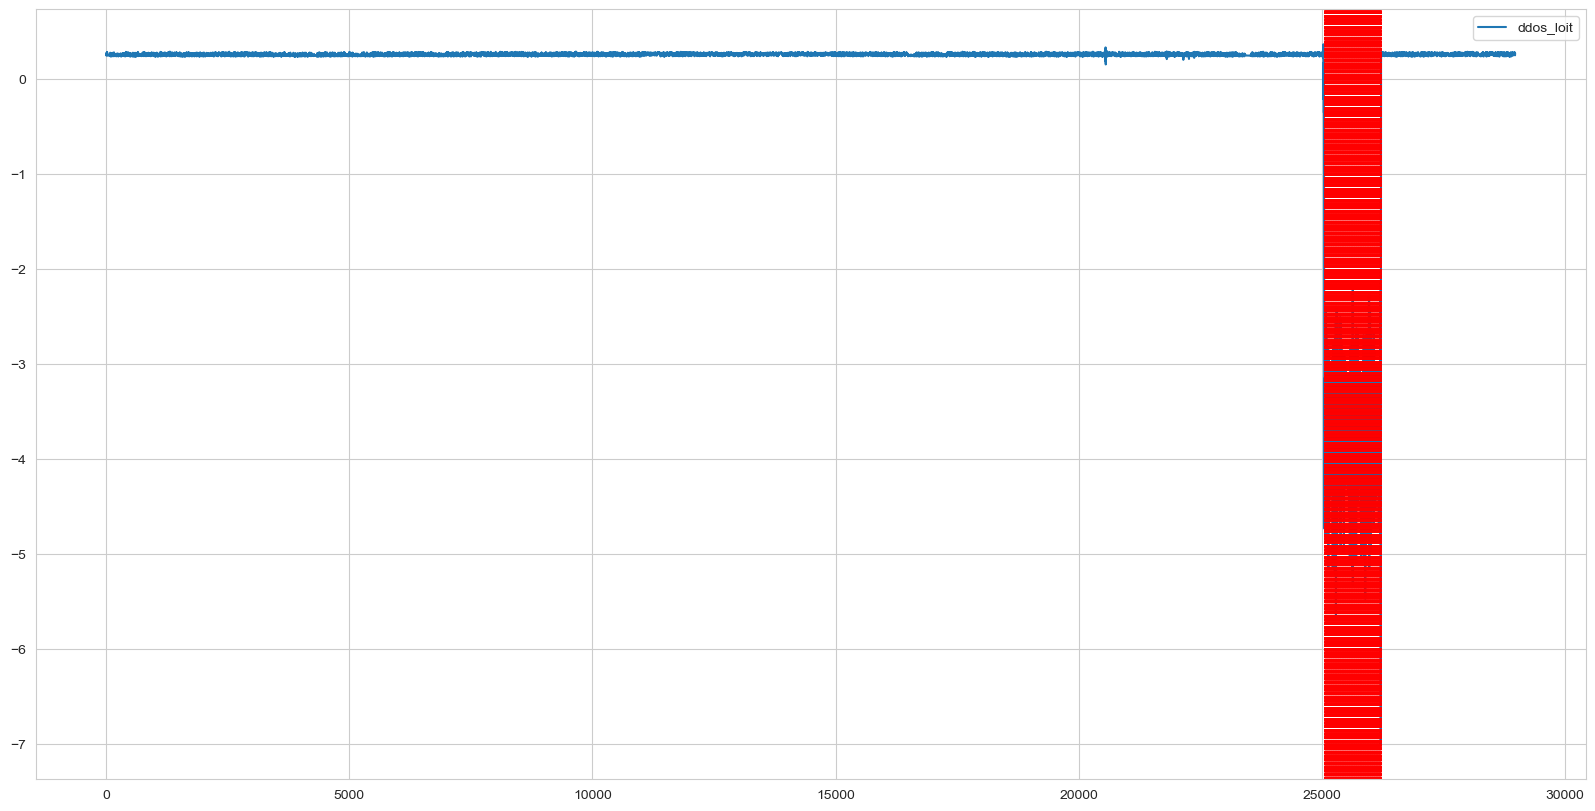

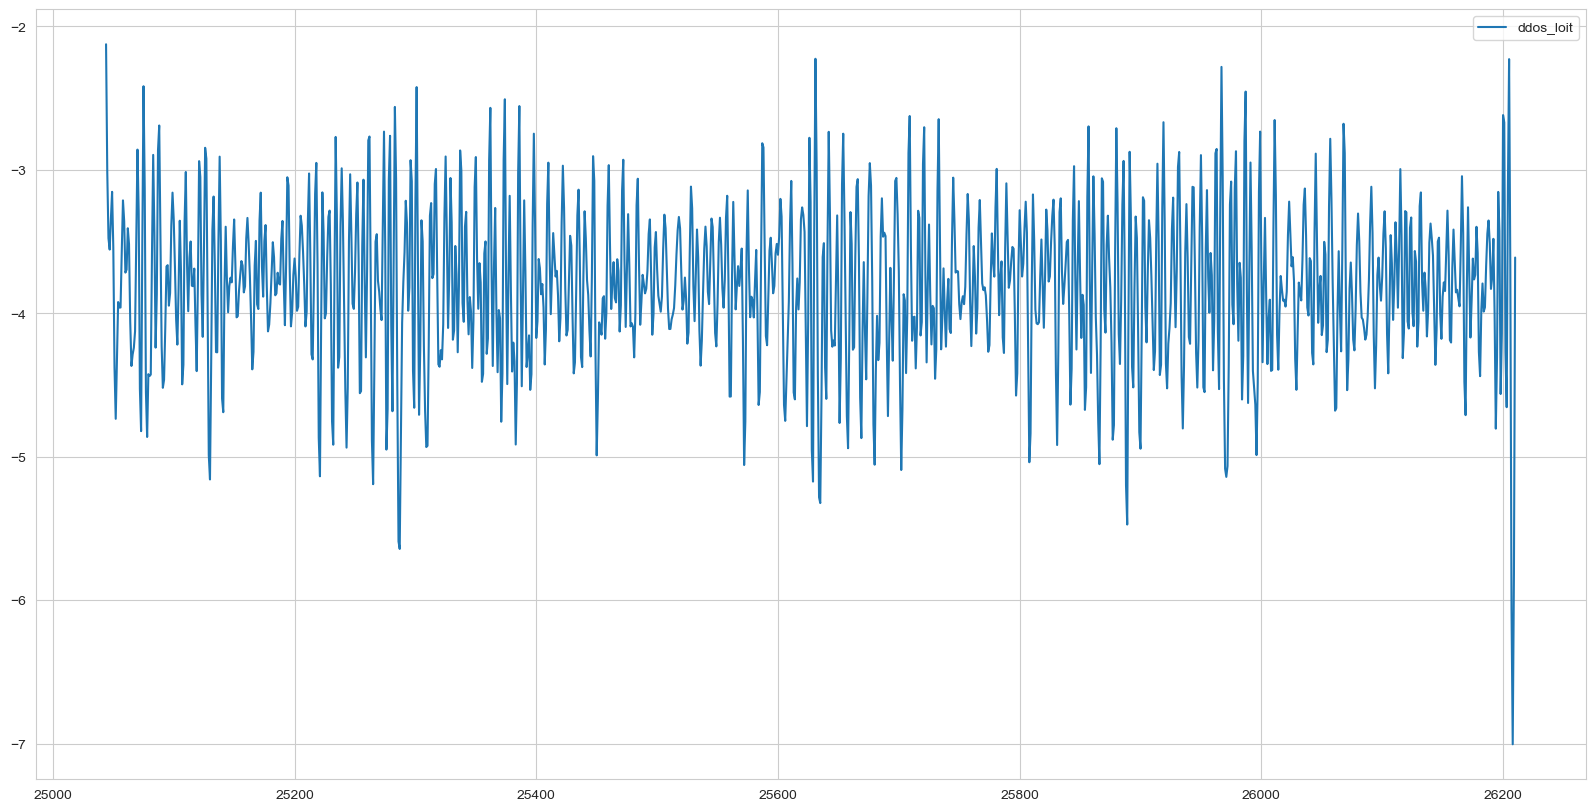

In [16]:
# plot outliers on test data

plt.figure(figsize=(20, 10))
plt.plot(X_test)

# for i in range(len(X_test[y_pred == -1])):
#     plt.axvline(, 0, 1, color='r', linestyle='dashed')

for i in X_test[y_pred == -1].index:
    plt.axvline(i, 0, 1, color='r', linestyle='dashed', linewidth=0.5)

plt.legend(dwt_df.columns)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(X_test[y_pred == -1])
plt.legend(dwt_df.columns)
plt.show()

# evaluate model

In [17]:
best_params = study.best_params
clf_optimal = OneClassSVM(nu=best_params["nu"], gamma=best_params["gamma"], kernel='rbf')
clf_optimal.fit(X)

y_pred_optimal = clf_optimal.predict(X_test)

KeyError: 'nu'

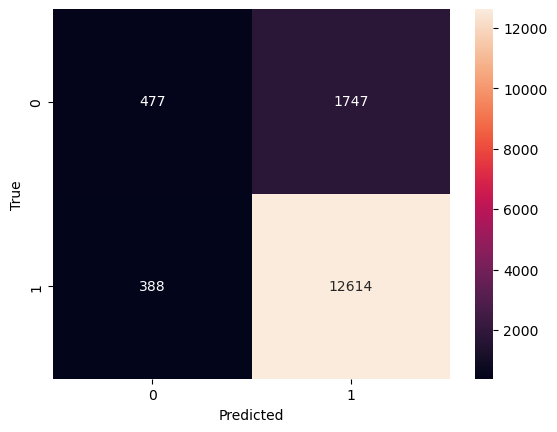

              precision    recall  f1-score   support

          -1       0.55      0.21      0.31      2224
           1       0.88      0.97      0.92     13002

    accuracy                           0.86     15226
   macro avg       0.71      0.59      0.62     15226
weighted avg       0.83      0.86      0.83     15226



In [337]:
# classification report
from sklearn.metrics import classification_report


sns.heatmap(confusion_matrix(y_true, y_pred_optimal), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred_optimal))

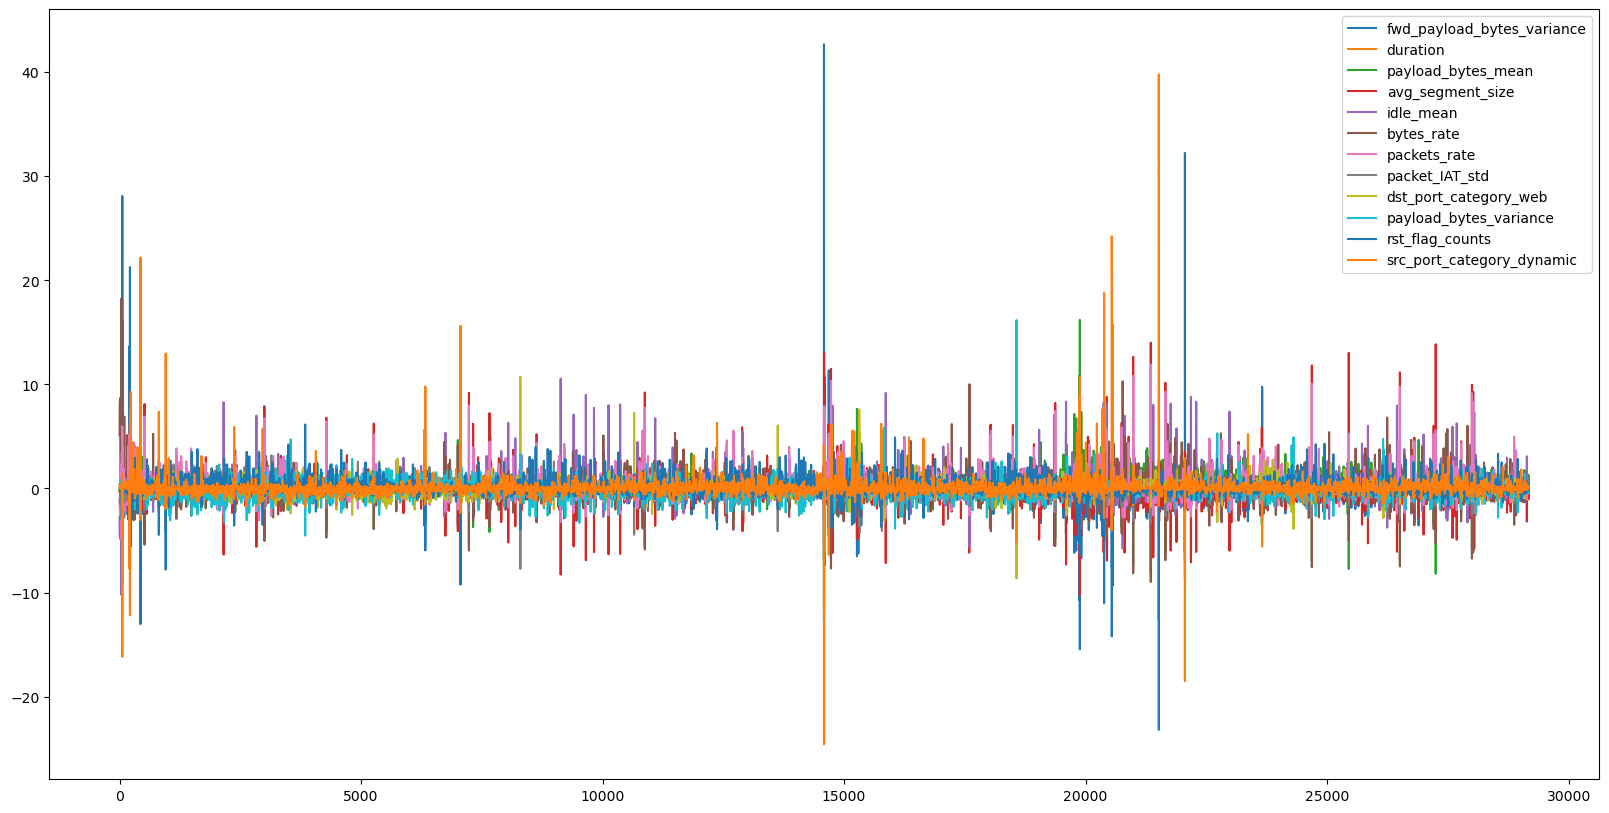

In [338]:
plt.figure(figsize=(20, 10))
plt.plot(X)
plt.legend(dwt_df.columns)
plt.show()

# for i, column in enumerate(dwt_df.columns):
#     plt.plot(X[:, i])

#     plt.title(dwt_df.columns[i])
#     plt.show()

In [ ]:
df = data.loc['2017-07-07']

df, labels = util.preprocess(df)

X_mal = scaler.transform(df)

plt.figure(figsize=(20, 10))
plt.plot(X_mal)
plt.legend(df.columns)
plt.show()

# for i, column in enumerate(df.columns):
#     plt.plot(X[:, i])

#     plt.title(df.columns[i])
#     plt.show()

# plt.show()

TypeError: preprocess() missing 1 required positional argument: 'scaler'

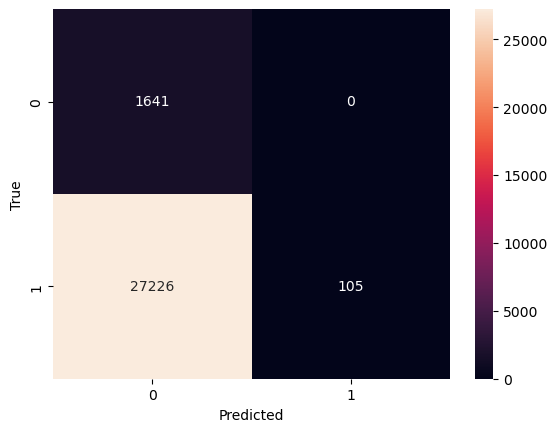

              precision    recall  f1-score   support

          -1       0.06      1.00      0.11      1641
           1       1.00      0.00      0.01     27331

    accuracy                           0.06     28972
   macro avg       0.53      0.50      0.06     28972
weighted avg       0.95      0.06      0.01     28972



In [ ]:
y_pred = clf.predict(X_mal)

# classification report
from sklearn.metrics import classification_report

sns.heatmap(confusion_matrix(labels, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(labels, y_pred))

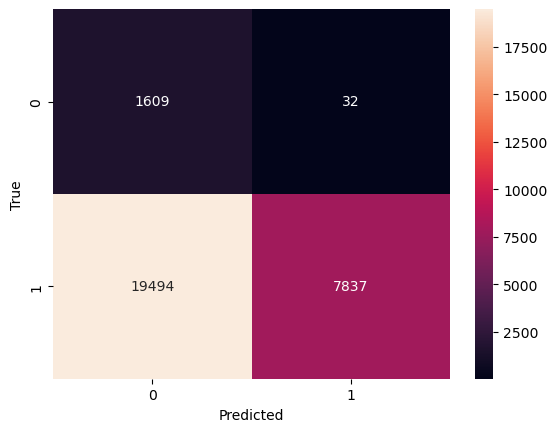

              precision    recall  f1-score   support

          -1       0.08      0.98      0.14      1641
           1       1.00      0.29      0.45     27331

    accuracy                           0.33     28972
   macro avg       0.54      0.63      0.29     28972
weighted avg       0.94      0.33      0.43     28972



In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest_clf = IsolationForest(contamination=0.01)
isolation_forest_clf.fit(X)

y_pred = clf.predict(X_mal)

# classification report
from sklearn.metrics import classification_report

sns.heatmap(confusion_matrix(labels, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(labels, y_pred))

In [83]:
import pickle

filename = 'one_class_svm_mon.sav'
pickle.dump(clf, open(filename, 'wb'))
pickle.dump(isolation_forest_clf, open('isolation_forest_mon.sav', 'wb'))

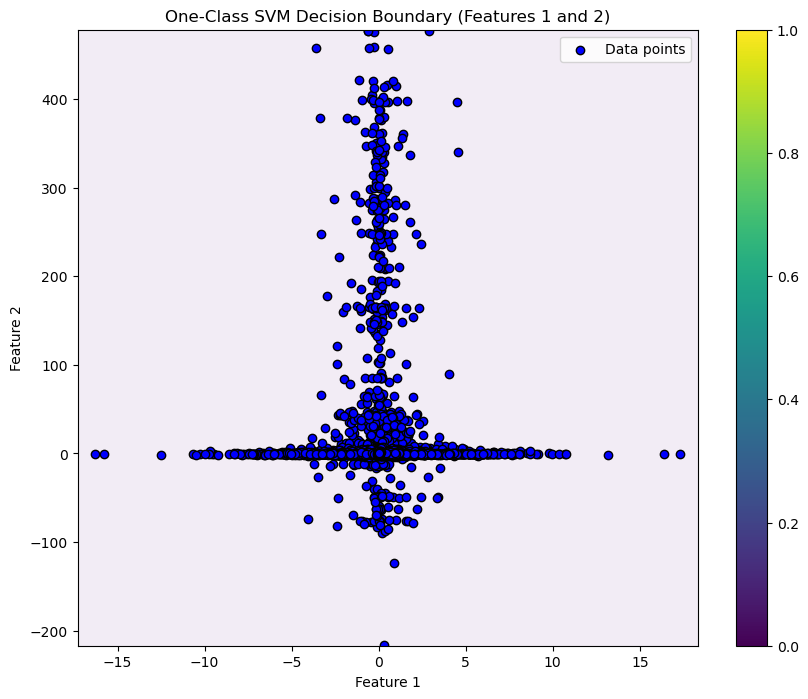

In [86]:
feature1, feature2 = 1, 2

x_min, x_max = X[:, feature1].min() - 1, X[:, feature1].max() + 1
y_min, y_max = X[:, feature2].min() - 1, X[:, feature2].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

grid_points = np.tile(X.mean(axis=0), (xx.ravel().shape[0], 1))
grid_points[:, feature1] = xx.ravel()
grid_points[:, feature2] = yy.ravel()

Z = clf.decision_function(grid_points)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.scatter(X[:, feature1], X[:, feature2], c='blue', edgecolors='k', label="Data points")
plt.title(f"One-Class SVM Decision Boundary (Features {feature1} and {feature2})")
plt.xlabel(f"Feature {feature1}")
plt.ylabel(f"Feature {feature2}")
plt.legend()
plt.colorbar()
plt.show()